In [1]:
import alpdesign
import numpy as np
import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
from jax.experimental import optimizers

### Initialize data

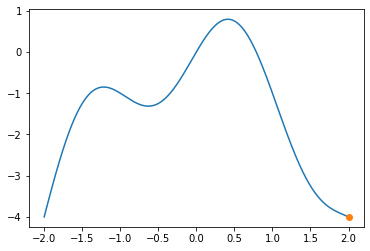

In [2]:
x = np.linspace(-2,2, 1000)
reps = np.array([2.0]).reshape(-1,1)
label_fxn = lambda x: np.sin(x * np.pi) - x ** 2
labels = label_fxn(reps)
plt.plot(x,  label_fxn(x))
plt.plot(reps, labels, 'o')

In [3]:
(4, *reps[0].shape)

(4, 1)

In [4]:
config = alpdesign.EnsembleBlockConfig()
forward_fxn_t, full_forward_fxn_t = alpdesign.build_model(config, without_rng=True)

In [5]:

batch_size = 16
def loop(key, reps, params):
    final_vec, *_ = alpdesign.alg_iter(key, reps, labels, forward_fxn_t,full_forward_fxn_t,config)
    # compute plot
    yhat_mu, yhat_std = [], []    
    plot_forward = partial(forward_t.apply, params)
    for xi in x:
        v = plot_forward(xi[np.newaxis])
        yhat_mu.append(float(v[0]))
        yhat_std.append(float(v[1]))
    
    reps = jnp.concatenate((reps, final_vec[np.newaxis]))
    return key, reps, yhat_mu, yhat_std, final_vec, params
    
    

In [6]:
key = jax.random.PRNGKey(0)

yhat_mus = []
yhat_stds = []
final_vecs = []
repss = []
params = None
for i in range(10):
    print(i)
    key, reps, yhat_mu, yhat_std, final_vec, params= loop(key, reps, params)
    print(final_vec)
    yhat_mus.append(yhat_mu)
    yhat_stds.append(yhat_std)
    final_vecs.append(final_vec)
    repss.append(reps)
    

0


TypeError: model_forward() takes 1 positional argument but 2 were given

In [ ]:
from celluloid import Camera
fig = plt.figure()
camera = Camera(fig)

for i in range(10):
    plt.plot(np.squeeze(repss[i][:-1]), label_fxn(np.squeeze(repss[i][:-1])), 'o', color='C0')
    plt.plot(x, yhat_mus[i], color='C1')
    plt.xlim(-2,2)
    #print(x.shape)
    #print()
    print(i)
    plt.ylim([-5, 1])
    plt.plot(final_vecs[i][0], label_fxn(final_vecs[i][0]), '*', color='C2')
    plt.plot(x, label_fxn(x), color='C3')
    plt.errorbar(x, yhat_mus[i], yerr=yhat_stds[i], color='C1', alpha=0.05)
    plt.legend(['step %d' % (i)] , markerscale=0.1)
    plt.title('Bayesian Optimization', fontsize=15)
    camera.snap()
animation = camera.animate(interval = 1000, repeat = True,
                           repeat_delay = 500)
animation.save('BO_1.gif', writer = 'imagemagick', dpi=180)